In [2]:
# libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch import nn # 'object-oriented'
from torch.nn import functional as F # 'functions'
from torch.utils.data import DataLoader, Sampler
from torchvision import transforms, datasets # useful for converting and structuring the MNIST data
from torchvision.utils import make_grid
import time
import copy
import random
import pickle
from PIL import Image
from collections import OrderedDict

from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cpu


In [4]:
# set reandom seeds to allow repeat test comparisons
torch.backends.cudnn.deterministic = True
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [5]:
base_path = '/Users/Steven/Documents/projects/data/lego/'

In [6]:
pickle_dir = base_path + 'pickles/'
# load landmarks
with open(pickle_dir + 'resized_img_dict_v01.pickle', 'rb') as handle:
    combined_dict = pickle.load(handle)

In [7]:
combined_dict.keys()

dict_keys(['fname', 'image', 'label', 'class'])

In [8]:
def load_imagelist2np(img_list):
    '''load PIL images from list and output as numpy array list'''
    img_list_np = []
    for img in img_list:
        img_list_np.append(np.array(img).astype('int16')) # convert to numpy array shape: height x width x channel
    
    return img_list_np

In [9]:
img_list_np = load_imagelist2np(combined_dict['image'])

In [10]:
img_data_tensor = torch.tensor(img_list_np)
print(img_data_tensor.shape)
img_data_tensor = img_data_tensor.permute(0, 3, 1, 2)
print(img_data_tensor.shape)

torch.Size([1055, 32, 32, 3])
torch.Size([1055, 3, 32, 32])


In [11]:
class_tensor = torch.tensor(combined_dict['class'])

In [12]:
X_train, X_test, y_train, y_test, fname_train, fname_test = train_test_split(img_data_tensor, class_tensor, combined_dict['fname'], 
                                                                        test_size=0.20, stratify = class_tensor, random_state=42)
X_train, X_val, y_train, y_val, fname_train, fname_val = train_test_split(X_train, y_train, fname_train, 
                                                                        test_size=0.20*(len(img_data_tensor)/len(X_train)), stratify = y_train, random_state=42)

In [13]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(len(fname_train))
print(len(fname_val))
print(len(fname_test))

torch.Size([633, 3, 32, 32])
torch.Size([211, 3, 32, 32])
torch.Size([211, 3, 32, 32])
633
211
211


tensor(0)


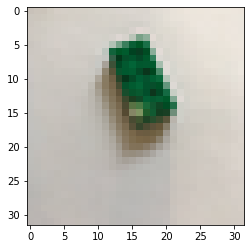

In [14]:
print(y_train[1])
plt.imshow(X_train[1].permute(1, 2, 0))
plt.show()

In [15]:
X_train = X_train[:1]
print(X_train.shape)

torch.Size([1, 3, 32, 32])


In [16]:
y_train = y_train[:1]
print(X_train.shape)

torch.Size([1, 3, 32, 32])


In [17]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 1)
        self.fc1 = nn.Linear(1024, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(running_loss)
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

print('Finished Training')

21.806983947753906
1.4662635294371285e-05
Finished Training
